In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

DAM_ID = "602041282223010"


st_date = datetime(2024, 1, 1, 0, 0, 0)
ed_date = datetime(2024, 12, 31, 23, 59, 59)


def parse_df(df):
    df = df.iloc[2:].copy()  # .copy()を追加してSettingWithCopyWarningを回避

    df["date"] = df["#年月日"] + " " + df["時刻"]
    # 24:00を00:00に変換し、日付を1日進める
    df["date"] = df["date"].str.replace(" 24:00", " 00:00")
    # 24:00だった行の日付を1日進める処理
    mask = df["時刻"] == "24:00"
    if mask.any():
        # 日付文字列をdatetimeに変換してから1日加算
        temp_dates = pd.to_datetime(df.loc[mask, "#年月日"], format="%Y/%m/%d") + pd.Timedelta(
            days=1
        )
        df.loc[mask, "date"] = temp_dates.dt.strftime("%Y/%m/%d") + " 00:00"
    df = df.drop(columns=["#年月日", "時刻"])
    df.index = pd.to_datetime(df["date"], format="mixed")
    df = df.drop(columns=["date"], axis=1)
    return df


tmp_date = st_date
df_list = []
while st_date <= ed_date:
    df_tmp = pd.read_csv(
        f"rawfile/{DAM_ID}/dam_{st_date.strftime('%Y%m')}.dat",
        encoding="Shift_JIS",
        skiprows=6,
        header=0,
        index_col=None,
    )
    df_tmp = parse_df(df_tmp)
    df_list.append(df_tmp)
    st_date += relativedelta(months=1)

df = pd.concat(df_list)

attributes = [
    "流域平均雨量属性",
    "貯水量属性",
    "流入量属性",
    "放流量属性",
    "貯水率属性",
]

for att in attributes:
    mask = (df[att] == "-") | (df[att] == "$") | (df[att] == "#")
    if mask.any():
        df.loc[mask, att.split("属性")[0]] = np.nan

df.to_csv(f"rawfile/{DAM_ID}/dam_concat.csv", encoding="Shift_JIS")

異常検知結果:
  急上昇異常: 38件
  急下降異常: 2件
  総異常件数: 40件
  異常率: 0.46%


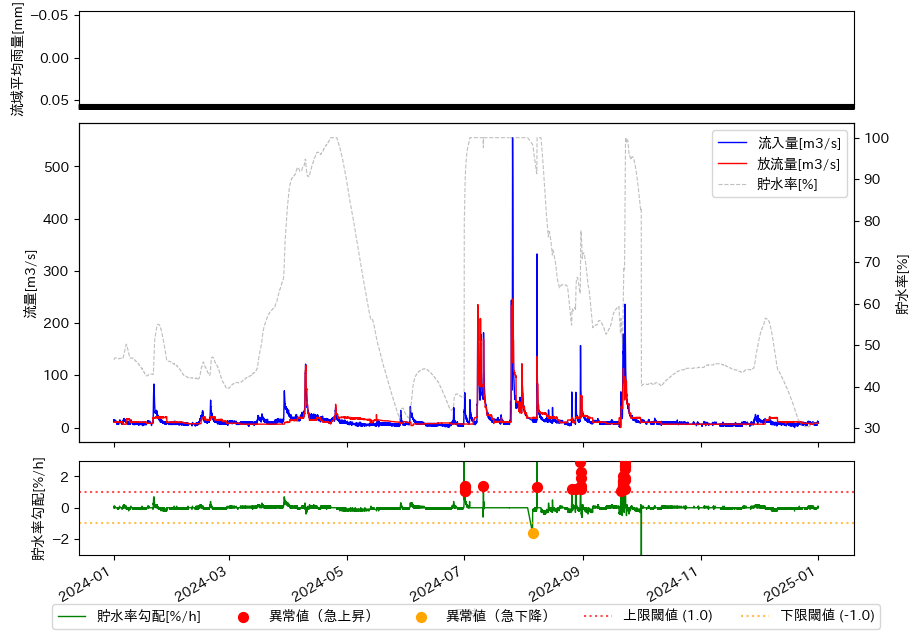

In [25]:
# 異常検知のための閾値設定　
#============================================
#! NOTE: ここを変更すること
threshold_upper = 1.0  # 上限閾値（急激な上昇）
threshold_lower = -1.0  # 下限閾値（急激な下降）
# ===========================================

plt.figure(figsize=(10, 8))
# df_tmp = df.loc["2025/8/10 21:00":"2025/8/11 17:00"]
# df_tmp = df.loc["2023/1/1 03:00":"2023/12/15 18:00"]
df_tmp = df


ax1 = plt.subplot(5, 1, 1)
df_tmp["流域平均雨量"].plot(kind="bar", ax=ax1)
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.set_xlabel("")

ax2 = plt.subplot(5, 1, (2, 4))
ax2_right = ax2.twinx()
df_tmp["貯水率"].plot(
    ax=ax2_right, label="貯水率[%]", color="gray", linestyle="--", linewidth=0.8, alpha=0.5
)
df_tmp["流入量"].plot(ax=ax2, label="流入量[m3/s]", color="blue", linewidth=1, alpha=1)
df_tmp["放流量"].plot(ax=ax2, label="放流量[m3/s]", color="red", linewidth=1, alpha=1)
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2_right.set_xticklabels([])
ax2_right.set_xlabel("")

# ax3 = plt.subplot(5, 1, 5)
# # 貯水率の勾配を計算
# df_tmp["貯水率_grad"] = df_tmp["貯水率"].diff()
# df_tmp["貯水率_grad"].plot(ax=ax3, label="貯水率勾配[%/h]", color="green", linewidth=1)
# ax3.set_ylabel("貯水率勾配[%/h]")
# ax3.set_xlabel("日時")
# ax3.set_ylim(-2, 2)
# ax3.legend()
# 貯水率の異常検知
ax3 = plt.subplot(5, 1, 5)

# 貯水率の勾配を計算
df_tmp["貯水率_grad"] = df_tmp["貯水率"].diff()


# 正常範囲をプロット
df_tmp["貯水率_grad"].plot(ax=ax3, label="貯水率勾配[%/h]", color="green", linewidth=1)

# 異常値を検出してハイライト
anomaly_upper = df_tmp["貯水率_grad"] > threshold_upper
anomaly_lower = df_tmp["貯水率_grad"] < threshold_lower

if anomaly_upper.any():
    ax3.scatter(
        df_tmp.index[anomaly_upper],
        df_tmp["貯水率_grad"][anomaly_upper],
        color="red",
        s=50,
        label="異常値（急上昇）",
        zorder=5,
    )

if anomaly_lower.any():
    ax3.scatter(
        df_tmp.index[anomaly_lower],
        df_tmp["貯水率_grad"][anomaly_lower],
        color="orange",
        s=50,
        label="異常値（急下降）",
        zorder=5,
    )

# 閾値ラインを表示
ax3.axhline(
    y=threshold_upper, color="red", linestyle=":", alpha=0.7, label=f"上限閾値 ({threshold_upper})"
)
ax3.axhline(
    y=threshold_lower,
    color="orange",
    linestyle=":",
    alpha=0.7,
    label=f"下限閾値 ({threshold_lower})",
)

ax3.set_ylabel("貯水率勾配[%/h]")
ax3.set_xlabel("日時")
ax3.set_ylim(-3, 3)
ax3.legend(ncols=5, bbox_to_anchor=(0.5, -0.45), loc="upper center")

# 異常検知結果の統計情報を表示
total_anomalies = anomaly_upper.sum() + anomaly_lower.sum()
print(f"異常検知結果:")
print(f"  急上昇異常: {anomaly_upper.sum()}件")
print(f"  急下降異常: {anomaly_lower.sum()}件")
print(f"  総異常件数: {total_anomalies}件")
print(f"  異常率: {total_anomalies/len(df_tmp)*100:.2f}%")

# 両軸の凡例を統合
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

ax1.set_ylabel("流域平均雨量[mm]")
ax2.set_ylabel("流量[m3/s]")
ax2_right.set_ylabel("貯水率[%]")

plt.show()

## やること
1. 大雨イベントの抽出（気象庁の顕著イベントリストから）
3. 事前・予備放流有無
4. 当たり・外れの判断

- 放流あり　--> 被害あり --> もっと放流できた
- 放流あり --> 水位回復無し --> 空振り
- 放流あり --> 水位回復無し --> 空振り
- 放流無し --> 被害あり --> 見逃し